In [1]:
from efaar_benchmarking.data_loading import load_periscope
from efaar_benchmarking.efaar import *
from efaar_benchmarking.constants import *
from efaar_benchmarking.benchmarking import univariate_consistency_benchmark, multivariate_benchmark
from efaar_benchmarking.plotting import plot_recall

recall_threshold_pairs = []
start = 0.01
end = 0.99
step = 0.01

while start <= .105 and end >= .895:
    recall_threshold_pairs.append((round(start,2), round(end,2)))
    start += step
    end -= step

print(recall_threshold_pairs)

/Users/safiye.celik/.pyenv/versions/3.11.5/envs/eben/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/safiye.celik/.pyenv/versions/3.11.5/envs/eben/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/safiye.celik/.pyenv/versions/3.11.5/envs/eben/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[(0.01, 0.99), (0.02, 0.98), (0.03, 0.97), (0.04, 0.96), (0.05, 0.95), (0.06, 0.94), (0.07, 0.93), (0.08, 0.92), (0.09, 0.91), (0.1, 0.9)]


20419 perturbations exist in the map.
36942 relationships are used from the benchmark source CORUM
57779 relationships are used from the benchmark source HuMAP
17493 relationships are used from the benchmark source Reactome
11469 relationships are used from the benchmark source SIGNOR
54347 relationships are used from the benchmark source StringDB


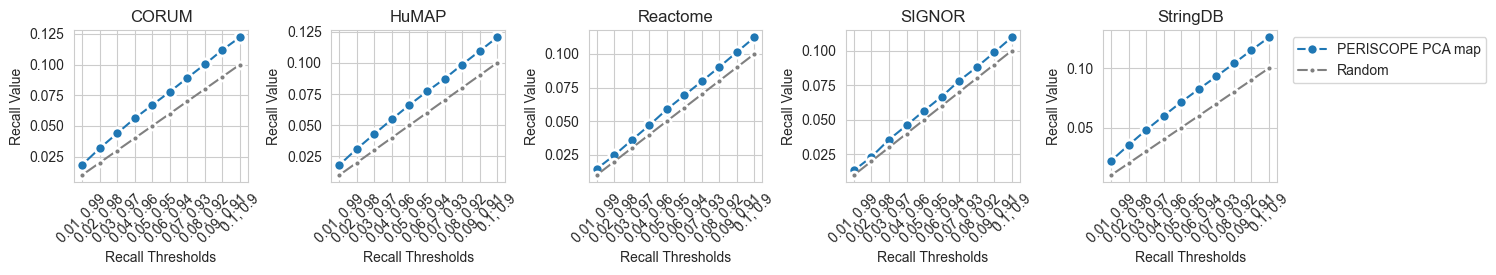

source
CORUM       0.067024
HuMAP       0.066322
Reactome    0.058709
SIGNOR      0.056587
StringDB    0.071522
Name: recall_0.05_0.95, dtype: float64
20419 perturbations exist in the map.
36942 relationships are used from the benchmark source CORUM
57779 relationships are used from the benchmark source HuMAP
17493 relationships are used from the benchmark source Reactome
11469 relationships are used from the benchmark source SIGNOR
54347 relationships are used from the benchmark source StringDB


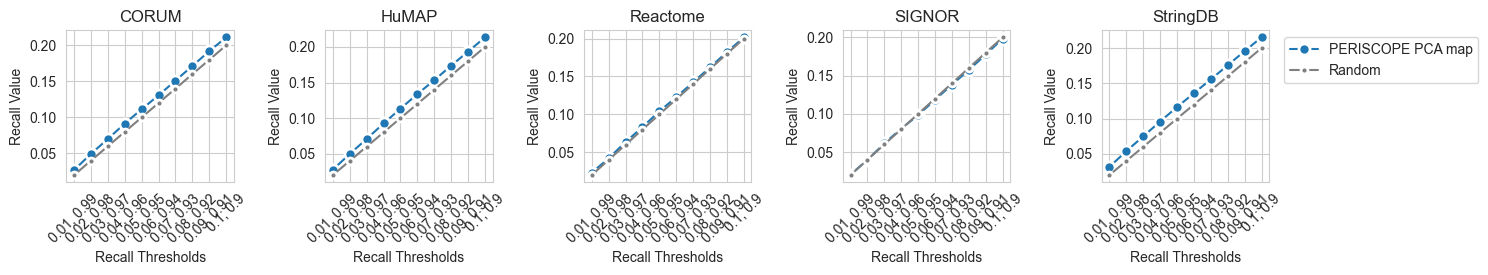

source
CORUM       0.111310
HuMAP       0.113328
Reactome    0.104042
SIGNOR      0.098439
StringDB    0.116382
Name: recall_0.05_0.95, dtype: float64
20419 perturbations exist in the map.
36942 relationships are used from the benchmark source CORUM
57779 relationships are used from the benchmark source HuMAP
17493 relationships are used from the benchmark source Reactome
11469 relationships are used from the benchmark source SIGNOR
54347 relationships are used from the benchmark source StringDB


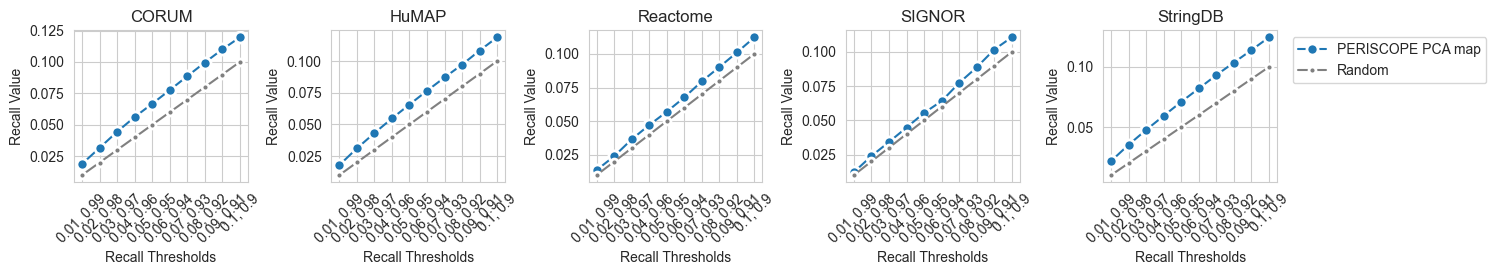

source
CORUM       0.066726
HuMAP       0.065716
Reactome    0.056994
SIGNOR      0.055454
StringDB    0.071007
Name: recall_0.05_0.95, dtype: float64
20419 perturbations exist in the map.
36942 relationships are used from the benchmark source CORUM
57779 relationships are used from the benchmark source HuMAP
17493 relationships are used from the benchmark source Reactome
11469 relationships are used from the benchmark source SIGNOR
54347 relationships are used from the benchmark source StringDB


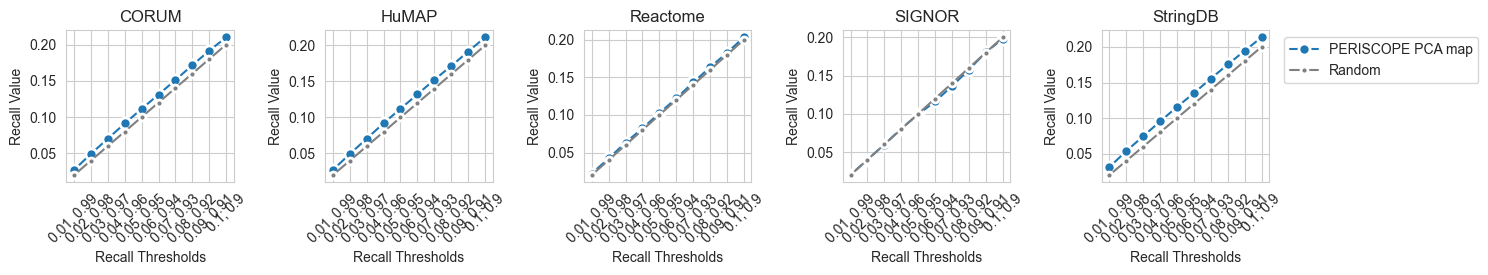

source
CORUM       0.111310
HuMAP       0.112134
Reactome    0.102441
SIGNOR      0.099311
StringDB    0.115664
Name: recall_0.05_0.95, dtype: float64


In [2]:
ct = "HeLa"
for n in [True, False]:
    features, metadata = load_periscope(cell_type=ct, normalized=n)
    embeddings = embed_align_by_pca(features.values, metadata, variance_or_ncomp=None, plate_col=PERISCOPE_PLATE_COL)
    embeddings = align_on_controls(embeddings, metadata, pert_col=PERISCOPE_PERT_LABEL_COL, control_key=PERISCOPE_CONTROL_PERT_LABEL, scale=True)
    # phenoprint_pvals = univariate_consistency_benchmark(embeddings, metadata, pert_col=PERISCOPE_PERT_LABEL_COL, keys_to_drop=[PERISCOPE_CONTROL_PERT_LABEL, 'negCtrl'])
    map_data = aggregate(embeddings, metadata, pert_col=PERISCOPE_PERT_LABEL_COL, control_key=PERISCOPE_CONTROL_PERT_LABEL)
    for right_sided in [True, False]:
        metrics = multivariate_benchmark(map_data, recall_thr_pairs=recall_threshold_pairs, pert_col=PERISCOPE_PERT_LABEL_COL, n_null_samples = 10000, n_iterations = 1, right_sided=right_sided)
        plot_recall({'PERISCOPE PCA map': metrics}, right_sided=right_sided)
        print(metrics.groupby('source')['recall_0.05_0.95'].mean())